<a href="https://colab.research.google.com/github/gerritgr/Alia/blob/main/AliaMolecule_Adversarially_Guided_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AliaMolecule - Adversarially Guided Probabilistic Diffusion



---






## Todo
- DEVICE
- positional encoding
- resnet units
- save loss list
- cosine schedule
- predict endpoint and not noise
- why is batch wrong

Molecules:
- remove hydrogen

- $t=0$ is original image.  => ($i=999$)
- $t=1$ means one noise addition was made.  => ($i=T-t=999-t$)
- $t=T=999$ is maximal addition. => ($i=0$)
- $T = TIMESTEPS-1$

## Setup

In [1]:
PROJECT_NAME = "AliaMolecule"

In [2]:
try:
  import torch_geometric
except:
  !pip install torch_geometric
  # Optional dependencies:
  !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
  !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu102.html --force-reinstall


In [3]:
try:
  import rdkit
except:
  !pip install rdkit

In [4]:
#!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu102.html --force-reinstall

In [5]:
import os
USE_COLAB = False
try:
  from google.colab import drive
  USE_COLAB = True
except:
  pass

if USE_COLAB and not os.path.exists('/content/drive'):
  drive.mount('/content/drive')

In [6]:
if USE_COLAB:
  dir_path = f'/content/drive/MyDrive/colab/{PROJECT_NAME}/'
  if not os.path.exists(dir_path):
    os.makedirs(dir_path)
  print("Current Working Directory: ", os.getcwd())
  if os.getcwd() != dir_path:
    os.chdir(dir_path)
    print("New Working Directory: ", os.getcwd())

Current Working Directory:  /content
New Working Directory:  /content/drive/MyDrive/colab/AliaMolecule


## Git Clone

In [7]:
#!rm -rf Alia && git clone https://github.com/gerritgr/Alia.git

### Imports

In [8]:
#%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100 # Set this to 300 to get better image quality
from PIL import Image # We use PIL to load images
import seaborn as sns
import imageio # to generate .gifs
import networkx as nx

# always good to have
import glob, random, os, traceback, time, copy
import pickle
import numpy as np
import networkx as nx
import math
from tqdm import tqdm

import torch
from torch import nn
from torch.optim import Adam
from torch.nn import Linear as Lin
from torch.nn import Sequential as Seq
from torch.nn import Linear
import torch.nn.functional as F
from torch.optim import Adam

import torch_geometric
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATv2Conv, GraphNorm, BatchNorm
from torch_geometric.utils import erdos_renyi_graph, to_networkx, from_networkx


### Hyperparams

In [9]:
# Mol Gen
NUM_SAMPLES = 500 # how many samples to generate for the trainings set
NUM_GRAPHS_TO_GENERATE = 10 # during inference
TRAIN_TEST_SPLIT = 0.8

INDICATOR_FEATURE_DIM = 1
FEATURE_DIM = 5 # (has to be the same for atom and bond)
ATOM_FEATURE_DIM = FEATURE_DIM
BOND_FEATURE_DIM = FEATURE_DIM
NON_NODES = [True] + [False]*5 + [True] * 5
NON_EDGES = [True] + [True]*5 + [False] * 5

TIME_FEATURE_DIM = 1



# General
EPOCHS = 100000
BATCH_SIZE = 1
LEARNING_RATE = 0.001
NUM_ROUNDS = 10
BASE_MODEL_EPOCHS = 20000
EPOCHS_DISC_MODEL = 101
EPOCHS_GUIDE_MODEL = 201
GUIDE_FRACTION = 20   # only apply guidacne in the last 1/4 of the process


# Diffusion
TIMESTEPS = 1000
START = 0.0001
END = 0.015
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#DEVICE = torch.device('cpu')
DEVICE

device(type='cuda')

## Utils

In [10]:
def save_model(model, optimizer, graph_loss_list, loss_list, epoch_i):
  if epoch_i == 0:
    return
  save_path = f"aliamol_model_epoch_{epoch_i:08}.pth"

  # Save the model state dict and the optimizer state dict in a dictionary
  torch.save({
              'epoch': epoch_i,
              'loss_list': loss_list,
              'graph_loss_list': graph_loss_list,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict()
              }, save_path)

def load_latest_checkpoint(model, optimizer, graph_loss_list, loss_list, epoch_i):
  try:
    checkpoint_paths = sorted(glob.glob("aliamolmodel_epoch_*.pth"))
    if len(checkpoint_paths) == 0:
      return model, optimizer, graph_loss_list, loss_list, epoch_i

    latest_checkpoint_path = checkpoint_paths[-1]
    checkpoint = torch.load(latest_checkpoint_path)

    # Assuming model and optim are your initialized model and optimizer
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_i = checkpoint['epoch']
    graph_loss_list = checkpoint['graph_loss_list']
    print(f"read checkpoint of epoch {epoch_i:08} from disc.")
  except:
    pass

  return model, optimizer, graph_loss_list, loss_list, epoch_i

## Build Dataset

In [11]:
# each node represents atom or bond
# thus, each row of data.x has the form TAAAAABBBBB
# T is 1 (atom) or -1 (bond). AAAAA is one-hot encoding of element (the five in qm9);
# BBBBB is one hot encoding of bond type, single, double, triple, ring,
# if a node is an atom then BBBBB is all -1, if it is a bond AAAAA is all -1
# The diffusion only happens on either AAAAA or BBBBB

In [12]:
#!cd Alia/smiles_to_pyg/ && mv molecule_load_and_convert2.py  molecule_load_and_convert3.py

In [13]:
def build_dataset(seed=1234):
  from Alia.smiles_to_pyg.molecule_load_and_convert3 import read_qm9
  dataset = read_qm9()
  dataset = [g for g in dataset if g.x.shape[0] > 1]
  random.Random(seed).shuffle(dataset)
  split = int(len(dataset)*TRAIN_TEST_SPLIT + 0.5)
  dataset_train = dataset[:split]
  dataset_test = dataset[split:]
  assert(dataset_train[0].x[0,:].numel() == INDICATOR_FEATURE_DIM + ATOM_FEATURE_DIM + BOND_FEATURE_DIM)

  return dataset_train, dataset_test


## Base Model

### Scheduler

In [14]:
def generate_schedule(start = START, end = END, timesteps=TIMESTEPS):
    """
    Generates a schedule of beta and alpha values for a forward process.

    Args:
    start (float): The starting value for the beta values. Default is START.
    end (float): The ending value for the beta values. Default is END.
    timesteps (int): The number of timesteps to generate. Default is TIMESTEPS.

    Returns:
    tuple: A tuple of three tensors containing the beta values, alpha values, and
    cumulative alpha values (alpha bars).
    """
    betas = torch.linspace(start, end, timesteps, device = DEVICE)
    #alphas = 1.0 - betas
    #alpha_bars = torch.cumprod(alphas, axis=0)
    assert(betas.numel() == TIMESTEPS)
    return betas

## Forward Process

In [15]:
def forward_diffusion(node_features, future_t):
  """
  Performs a forward diffusion process on an node_features tensor.
  Each row can theoreetically have its own future time point.
  Implements the second equation from https://youtu.be/a4Yfz2FxXiY?t=649
  """
  row_num = node_features.shape[0]
  feature_dim = node_features.shape[1]
  future_t = future_t.view(-1)
  assert(row_num == future_t.numel())

  betas = generate_schedule()

  noise = torch.randn_like(node_features, device=DEVICE)
  alphas = 1. - betas
  alphas_cumprod = torch.cumprod(alphas, axis=0)
  alphabar_t = torch.gather(alphas_cumprod, 0, future_t).view(row_num, 1)
  assert(alphabar_t.numel() == row_num)

  new_node_features_mean = torch.sqrt(alphabar_t) * node_features # column-wise multiplication, now matrix
  new_node_features_std = torch.sqrt(1.-alphabar_t) #this is a col vector
  new_node_features_std = new_node_features_std.repeat(1,feature_dim) #this is a matrix
  noisey_node_features =  new_node_features_mean + new_node_features_std * noise

  return noisey_node_features, noise

forward_diffusion(torch.tensor([1,2,3.], device=DEVICE).view(3,1), torch.tensor([0,0,999], device=DEVICE)), print(""), forward_diffusion(torch.tensor([1,2,3.], device=DEVICE).view(3,1), torch.tensor([999,999,999], device=DEVICE))

((tensor([[0.9916],
          [1.9964],
          [0.1035]], device='cuda:0'),
  tensor([[-0.8316],
          [-0.3454],
          [ 0.0360]], device='cuda:0')),
 None,
 (tensor([[ 0.5758],
          [-0.6691],
          [-2.2151]], device='cuda:0'),
  tensor([[ 0.5535],
          [-0.7142],
          [-2.2832]], device='cuda:0')))

## Base Model

### Model Spec

In [16]:
from torch_geometric.nn import PNA
from torch_geometric.utils import degree


def dataset_to_degree_bin(train_dataset):
  # Compute the maximum in-degree in the training data.
  max_degree = -1
  for data in train_dataset:
    data = data.to(DEVICE)
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    max_degree = max(max_degree, int(d.max()))

  deg = torch.zeros(max_degree + 1, dtype=torch.long, device=DEVICE)
  for data in train_dataset:
    data = data.to(DEVICE)
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    deg += torch.bincount(d, minlength=deg.numel())
  return deg

class PNAnet(torch.nn.Module):
  def __init__(self, train_dataset, hidden_channels=32, depth=4, dropout=0.05, towers=1, normalization=True, pre_post_layers=1):
    super(PNAnet, self).__init__()
    self.sigmoid = nn.Sigmoid()

    # Calculate x as the difference between mult_y and hidden_dim
    hidden_channels = towers * ((hidden_channels // towers) + 1) #tod fix
    #out_channels = towers * ((out_channels // towers) + 1)

    in_channels = INDICATOR_FEATURE_DIM + ATOM_FEATURE_DIM + BOND_FEATURE_DIM+ TIME_FEATURE_DIM #INDICATOR_FEATURE_DIM entries are noise free
    out_channels = FEATURE_DIM

    deg = dataset_to_degree_bin(train_dataset)
    aggregators = ['mean', 'min', 'max', 'std']
    scalers = ['identity', 'amplification', 'attenuation']
    self.normalization = BatchNorm(hidden_channels) if normalization else None
    self.pnanet = PNA(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=hidden_channels, num_layers=depth, aggregators=aggregators, scalers=scalers, deg=deg, dropout=dropout, towers=towers, norm=self.normalization, pre_layers=pre_post_layers, post_layers=pre_post_layers)

    self.final_mlp = Seq(Lin(hidden_channels, hidden_channels), nn.ReLU(), Lin(hidden_channels, hidden_channels), nn.ReLU(), Lin(hidden_channels, out_channels))


  def forward(self, x_in, t, edge_index):
    t = t.view(-1,TIME_FEATURE_DIM)
    x = torch.concat((x_in, t), dim=1)
    x = self.pnanet(x, edge_index)
    x = self.final_mlp(x)
    assert(x.numel() > 1 )

    #node_indicator = x_in[:,0] > 0
    #node_indicator = x_in[:,0] < 0
    #x[node_indicator, NON_NODES] = x_in[node_indicator, NON_NODES]
    #x[edge_indicator, NON_EDGES] = x_in[edge_indicator, NON_EDGES]

    return x


#model = PNAnet([data])

#model(data.x, data.edge_index, torch.ones(data.x.shape[0]))

### Train Epoch

In [20]:
def train_epoch(model, dataloader, optimizer):
  """
  Trains a denoising model for one epoch using a given data loader and optimization algorithm.

  Args:
  model: The denoising model.
  dataloader: The data loader for the training data.
  optimizer: The torch optimizer.

  Returns:
  float: The average loss for the epoch.
  """

  schedule = generate_schedule()
  model.train()
  start_time = time.time()
  loss_list = list()

  for g in tqdm(dataloader): #todo batches deactivated
    if g.x.shape[0] < 2:
      continue
    optimizer.zero_grad()

    g.to(DEVICE)
    num_graphs_in_batch = 1
    #num_graphs_in_batch = int(torch.max(g.batch).item()+1)
    future_t_select = torch.randint(0, TIMESTEPS, (num_graphs_in_batch,), device = DEVICE)
    future_t = torch.tensor([0]*g.x.shape[0], device=DEVICE)# torch.gather(future_t_select, 0, g.batch)
    assert(future_t.numel() == g.x.shape[0])

    mask = torch.concat((torch.tensor([False]*g.x.shape[0], device=DEVICE).view(-1,1), g.x[:,1:]>-0.5), dim=1) #this only works on original values
    x = g.x[mask].view(g.x.shape[0], FEATURE_DIM)
    x_with_noise, noise_gt = forward_diffusion(x, future_t)

    x_in = g.x.clone()
    x_in[mask] = x_with_noise.flatten()
    noise_pred = model(x_in, future_t, g.edge_index)

    loss = F.mse_loss(noise_gt, noise_pred)
    loss.backward()
    loss_list.append(loss.item())
    optimizer.step()


  return float(np.mean(loss_list)), time.time()-start_time

In [21]:
def train_epoch_test():
  dataset_train, dataset_test = build_dataset()
  data = dataset_train[0]
  model_base = PNAnet(dataset_train[:20]).to(DEVICE) #20 should be enough to estimate statistics

  t = torch.tensor([1.0]).repeat(data.x.shape[0])
  t = t.to(DEVICE)
  model_base(data.x, t, data.edge_index)
  dataloader = DataLoader(dataset_train[:20], batch_size=1, shuffle=True)
  optimizer = Adam(model_base.parameters(), lr = LEARNING_RATE)

  return train_epoch(model_base, dataloader, optimizer)

train_epoch_test()

100%|██████████| 20/20 [00:00<00:00, 61.41it/s]


(1.0211095273494721, 0.3293795585632324)

### Training Loop

In [22]:
def plot_list(xy_data, filename, title="", xlabel="", ylabel=""):
  plt.clf()
  plt.plot([x for x, y in xy_data], [y for x, y in xy_data])
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.savefig(filename)

  with open(filename+".pickle", 'wb') as f:
    pickle.dump(xy_data, f)

In [23]:
def train_base_model(train_loader, epoch_num=None):
  print("train base model")

  dataset_train = train_loader.dataset
  model_base = PNAnet(dataset_train)
  model_base = model_base.to(DEVICE)

  lr = LEARNING_RATE
  if BATCH_SIZE > 1:
    lr = lr/100.0
  optimizer = Adam(model_base.parameters(), lr = LEARNING_RATE)
  loss_list = list()
  graph_loss_list = list()
  model_base, optimizer, graph_loss_list, loss_list, epoch_start = load_latest_checkpoint(model_base, optimizer, graph_loss_list, loss_list, epoch_i=0)

  epoch_num = epoch_num if epoch_num is not None else EPOCHS
  epoch_start = min(epoch_start, epoch_num)


  for epoch_i in range(epoch_start,epoch_num):
    try:
      loss, time_elapsed = train_epoch(model_base, train_loader, optimizer)
      loss_list.append((epoch_i, loss))
      if epoch_i % 1 == 0 or epoch_i == epoch_num - 1:
        plot_list(loss_list, "train_base.png", title="train loss base model", xlabel='epoch', ylabel='loss')
        print(f"loss in epoch {epoch_i:07} is: {loss:05.4f} with mean loss {np.mean([y for x,y in loss_list] + [loss]):05.4f} with runtime {time_elapsed:05.4f}")

      if (epoch_i % 10 == 0 and epoch_i > 100) or epoch_i == epoch_num - 1:
        #graphs = generate_examples(model_base, epoch_i, betas, dataset_train)
        #graph_loss_list.append(compute_generation_loss(graphs, None))
        #print(f"generation loss: {graph_loss_list[-1]:06.4f}")
        #plot_base(graph_loss_list, loss_list)
        save_model(model_base, optimizer, graph_loss_list, loss_list, epoch_i+1)

    except Exception as e:
      print("An error occurred during training: \n", str(e))
      traceback.print_exc()
      raise e


  return model_base

train base model


100%|██████████| 20/20 [00:00<00:00, 63.31it/s]


loss in epoch 0000000 is: 1.0306 with mean loss 1.0306 with runtime 0.3208


100%|██████████| 20/20 [00:00<00:00, 62.09it/s]


loss in epoch 0000001 is: 0.9780 with mean loss 0.9955 with runtime 0.3265


100%|██████████| 20/20 [00:00<00:00, 64.21it/s]


loss in epoch 0000002 is: 1.0340 with mean loss 1.0192 with runtime 0.3154


100%|██████████| 20/20 [00:00<00:00, 64.05it/s]


loss in epoch 0000003 is: 0.9960 with mean loss 1.0069 with runtime 0.3163


100%|██████████| 20/20 [00:00<00:00, 61.08it/s]


loss in epoch 0000004 is: 1.0057 with mean loss 1.0083 with runtime 0.3324


100%|██████████| 20/20 [00:00<00:00, 64.42it/s]


loss in epoch 0000005 is: 0.9770 with mean loss 0.9997 with runtime 0.3150


100%|██████████| 20/20 [00:00<00:00, 62.65it/s]


loss in epoch 0000006 is: 0.9757 with mean loss 0.9966 with runtime 0.3241


100%|██████████| 20/20 [00:00<00:00, 65.13it/s]


loss in epoch 0000007 is: 1.0039 with mean loss 1.0005 with runtime 0.3112


100%|██████████| 20/20 [00:00<00:00, 65.61it/s]


loss in epoch 0000008 is: 0.9745 with mean loss 0.9950 with runtime 0.3097


100%|██████████| 20/20 [00:00<00:00, 61.73it/s]


loss in epoch 0000009 is: 1.0288 with mean loss 1.0030 with runtime 0.3297


100%|██████████| 20/20 [00:00<00:00, 66.43it/s]


loss in epoch 0000010 is: 0.9883 with mean loss 0.9984 with runtime 0.3062


100%|██████████| 20/20 [00:00<00:00, 65.89it/s]


loss in epoch 0000011 is: 0.9742 with mean loss 0.9955 with runtime 0.3076


100%|██████████| 20/20 [00:00<00:00, 66.11it/s]


loss in epoch 0000012 is: 1.0016 with mean loss 0.9979 with runtime 0.3071


100%|██████████| 20/20 [00:00<00:00, 65.28it/s]


loss in epoch 0000013 is: 1.0114 with mean loss 0.9994 with runtime 0.3098


100%|██████████| 20/20 [00:00<00:00, 67.03it/s]


loss in epoch 0000014 is: 0.9584 with mean loss 0.9935 with runtime 0.3034


100%|██████████| 20/20 [00:00<00:00, 58.47it/s]


loss in epoch 0000015 is: 0.9804 with mean loss 0.9941 with runtime 0.3468


100%|██████████| 20/20 [00:00<00:00, 62.06it/s]


loss in epoch 0000016 is: 1.0179 with mean loss 0.9975 with runtime 0.3292


100%|██████████| 20/20 [00:00<00:00, 52.88it/s]


loss in epoch 0000017 is: 0.9904 with mean loss 0.9956 with runtime 0.3840


100%|██████████| 20/20 [00:00<00:00, 62.51it/s]


loss in epoch 0000018 is: 1.0351 with mean loss 0.9999 with runtime 0.3244


100%|██████████| 20/20 [00:00<00:00, 59.88it/s]


loss in epoch 0000019 is: 1.0157 with mean loss 0.9997 with runtime 0.3426


100%|██████████| 20/20 [00:00<00:00, 61.86it/s]


loss in epoch 0000020 is: 1.0389 with mean loss 1.0025 with runtime 0.3278


100%|██████████| 20/20 [00:00<00:00, 65.37it/s]


loss in epoch 0000021 is: 0.9710 with mean loss 0.9982 with runtime 0.3115


100%|██████████| 20/20 [00:00<00:00, 68.07it/s]


loss in epoch 0000022 is: 1.0059 with mean loss 1.0000 with runtime 0.3003


100%|██████████| 20/20 [00:00<00:00, 66.61it/s]


loss in epoch 0000023 is: 0.9883 with mean loss 0.9988 with runtime 0.3057


100%|██████████| 20/20 [00:00<00:00, 65.93it/s]


loss in epoch 0000024 is: 0.9655 with mean loss 0.9966 with runtime 0.3073


100%|██████████| 20/20 [00:00<00:00, 67.08it/s]


loss in epoch 0000025 is: 1.0370 with mean loss 1.0008 with runtime 0.3021


100%|██████████| 20/20 [00:00<00:00, 65.58it/s]


loss in epoch 0000026 is: 0.9663 with mean loss 0.9970 with runtime 0.3093


100%|██████████| 20/20 [00:00<00:00, 66.95it/s]


loss in epoch 0000027 is: 1.0039 with mean loss 0.9986 with runtime 0.3040


100%|██████████| 20/20 [00:00<00:00, 65.78it/s]


loss in epoch 0000028 is: 0.9602 with mean loss 0.9958 with runtime 0.3088


100%|██████████| 20/20 [00:00<00:00, 58.78it/s]


loss in epoch 0000029 is: 0.9873 with mean loss 0.9964 with runtime 0.3452


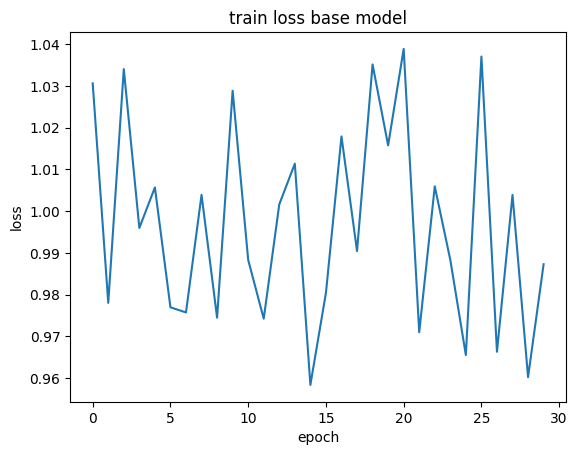

In [26]:
def train_base_model_test():
  dataset_train, dataset_test = build_dataset()
  dataloader = DataLoader(dataset_train[:20], batch_size=1, shuffle=True)

  train_base_model(dataloader, epoch_num=30)
#train_base_model_test()

In [29]:
!ls

Alia  train_base.png  train_base.png.pickle


## Putting Everything Together

In [ ]:
dataset_base, dataset_base_test = build_dataset()
dataloader_base = DataLoader(dataset_base, batch_size=BATCH_SIZE, shuffle=True)
model_base = train_base_model(dataloader_base, epoch_num = BASE_MODEL_EPOCHS)
model_cassandra = None
# TODO test set train

for round_i in range(NUM_ROUNDS):
  model_base = train_base_model(dataloader_base)

  #samples = sample_base_model(model_base, round_i, model_guide=model_cassandra, num=NUM_SAMPLES)  #TODO
  #plot_samples(samples, model_disc=None, round_i=round_i)
  #dataloader_disc = get_merged_dataloader(samples[:num_samples_train], dataset_base)
  #dataloader_disc_test = get_merged_dataloader(samples[num_samples_train:], dataset_base_test)
  #model_cassandra = train_cassandra_model(dataloader_disc, dataloader_disc_test, round_i)
  #new_epoch_num = BASE_MODEL_EPOCHS + (round_i+1)*int(BASE_MODEL_EPOCHS*0.2)
  #model_base = train_base_model(dataloader_base, epoch_num = new_epoch_num)

#samples = sample_base_model(model_base, round_i=NUM_ROUNDS, model_guide=model_cassandra, num=NUM_SAMPLES)

train base model


 71%|███████   | 76078/107105 [25:51<10:43, 48.23it/s]

In [ ]:
z = z/0

# Old

## Utils

In [ ]:
G = nx.star_graph(10)

nx.draw(G, with_labels=True, node_color='lightblue', node_size=800, font_weight='bold')
plt.show()

In [ ]:
def get_weights(g):
  edge_indices = g.x[:,0] < 0.1
  edge_weights = g.x[:,1]
  return edge_weights[edge_indices]

def set_weights(g, w):
  edge_indices = g.x[:,0] < 0.1
  g.x[edge_indices,1] = w
  return g

def get_edge_index(g):
  return g.x[:,0] < 0.1

In [ ]:
def transform_graph(graph, make_complete=False):
  # create graph where each edge becomes a node with weight 1
  # if make_complete, each non-egde becomes node with weight -1

  graph = nx.convert_node_labels_to_integers(graph, ordering="sorted")

  transformed_graph = nx.Graph()

  for u, v in graph.edges():
    new_node = (u+v)*1000000+100*(min(u,v)+1)+10000000000*max(u,v)
    transformed_graph.add_edge(u, new_node)
    transformed_graph.add_edge(new_node, v)
    transformed_graph.nodes[u]['is_real'] = 1
    transformed_graph.nodes[v]['is_real'] = 1
    transformed_graph.nodes[new_node]['is_real'] = 0
    transformed_graph.nodes[u]['weight'] = 0.0
    transformed_graph.nodes[v]['weight'] = 0.0
    transformed_graph.nodes[new_node]['weight'] = EDGE_INDICATOR


  if make_complete:
    for u in graph.nodes():
      for v in graph.nodes():
        if u > v and not graph.has_edge(u, v) and not graph.has_edge(v, u):
          new_node = (u+v)*1000000+100*(min(u,v)+1)+10000000000*max(u,v)+10
          transformed_graph.add_edge(u, new_node)
          transformed_graph.add_edge(new_node, v)
          transformed_graph.nodes[u]['is_real'] = 1
          transformed_graph.nodes[v]['is_real'] = 1
          transformed_graph.nodes[new_node]['is_real'] = 0
          transformed_graph.nodes[new_node]['weight'] = NO_EDGE_INDICATOR

  transformed_graph = nx.convert_node_labels_to_integers(transformed_graph, ordering="sorted")
  return transformed_graph


In [ ]:
def transform_to_complete_graph(graph):
  global EDGE_INDEX_STORAGE
  # create graph where each edge becomes a node with weight 1
  # if make_complete, each non-egde becomes node with weight -1

  graph_node_num = graph.number_of_nodes()
  number_nodes_in_transformed_graph = graph_node_num*(graph_node_num+1)/2 #+ graph_node_num
  graph = nx.convert_node_labels_to_integers(graph, ordering="sorted")

  transformed_graph = nx.Graph()
  nodes = range(graph_node_num)

  for u in nodes:
    for v in nodes:
      if u>=v:
        continue
      new_node = (u+v+1)*1000000+100*(min(u,v)+1)+10000000000*max(u,v)+10+u+20*(v+1)
      transformed_graph.add_edge(u, new_node)
      transformed_graph.add_edge(new_node, v)
      transformed_graph.nodes[u]['is_real'] = 1
      transformed_graph.nodes[v]['is_real'] = 1
      transformed_graph.nodes[new_node]['is_real'] = 0

      transformed_graph.nodes[u]['weight'] = 0.0
      transformed_graph.nodes[v]['weight'] = 0.0
      if graph.has_edge(u, v) or graph.has_edge(v, u):
        transformed_graph.nodes[new_node]['weight'] = EDGE_INDICATOR
      else:
        transformed_graph.nodes[new_node]['weight'] = NO_EDGE_INDICATOR

  transformed_graph = nx.convert_node_labels_to_integers(transformed_graph, ordering="sorted")
  assert(number_nodes_in_transformed_graph == transformed_graph.number_of_nodes())
  return transformed_graph


In [ ]:
# Transform the graph
transformed_G = transform_graph(G)

# Visualize the transformed graph
node_color = ['lightblue' if transformed_G.nodes[node]['is_real'] == 1 else 'gray' for node in transformed_G.nodes()]

nx.draw(transformed_G, with_labels=True, node_size=800, font_weight='bold', node_color=node_color)
plt.show()


In [ ]:
G = nx.star_graph(3)


# Transform the graph
transformed_G  = transform_graph(G, make_complete=True)
#transformed_G  = transform_to_complete_graph(G)

# Visualize the transformed graph
def get_node_color(g, v):
  if g.nodes[v]['is_real'] == 1:
    return "lightblue"
  if g.nodes[v]['weight'] > 0.5:
    return "gray"
  return "lightgray"

node_color = [get_node_color(transformed_G, node) for node in transformed_G.nodes()]

nx.draw(transformed_G, with_labels=True, node_size=800, font_weight='bold', node_color=node_color)
plt.show()


In [ ]:
G = nx.star_graph(3)
transformed_G  = transform_graph(G, make_complete=True)
transformed_G2 = transform_to_complete_graph(G)

for v_i in transformed_G.nodes:
  print(transformed_G.nodes(data=True)[v_i])
  print(transformed_G2.nodes(data=True)[v_i])
  print(" ")

#transformed_G.nodes(data=True), transformed_G2.nodes(data=True)

In [ ]:
transformed_G.nodes(data=True)

In [ ]:
g = from_networkx(transformed_G, group_node_attrs=["is_real", "weight"])
g, g.x, g.edge_index

In [ ]:
class ShuffleList:
    def __init__(self, data):
        self.data = data
        self.index = 0

    def __iter__(self):
        random.shuffle(self.data)
        self.index = 0
        return self

    def __next__(self):
        if self.index < len(self.data):
            value = self.data[self.index]
            self.index += 1
            return value
        else:
            raise StopIteration

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

#### Plotting

In [ ]:
def remove_edges(graph, threshold = 0.0):
    # Create a deep copy of the graph
    new_graph = copy.deepcopy(graph)

    # List to store edges to be removed
    edges_to_remove = []

    # Find edges with weight < 0.5
    for u, v, data in new_graph.edges(data=True):
        if 'weight' in data and data['weight'] < threshold:
            edges_to_remove.append((u, v))

    # Remove edges
    for edge in edges_to_remove:
        new_graph.remove_edge(*edge)

    return new_graph

def reduce_nx_graph(g_old):
  g_new = nx.Graph()
  for v_i in g_old.nodes():
    if g_old.nodes[v_i]['x'][0] > 0.1:
      g_new.add_node(v_i)
      g_new.nodes[v_i]['x'] = g_old.nodes[v_i]['x']

  for v_i in g_old.nodes():
    if g_old.nodes[v_i]['x'][0] < 0.1:
      neigh_list = list(g_old.neighbors(v_i))
      if len(neigh_list) != 2:
        print(neigh_list)
      assert(len(neigh_list) == 2)
      g_new.add_edge(neigh_list[0], neigh_list[1], weight = g_old.nodes[v_i]['x'][1])
  return g_new

def pyg_graph_to_nx(g_pyg, edge_weights):
  g_pyg = g_pyg.clone()

  edge_indices = g_pyg.x[:,0] < 0.1
  g_pyg.x[edge_indices,1] = edge_weights

  g_nx = to_networkx(g_pyg, node_attrs=['x'], to_undirected=True)
  g_nx = reduce_nx_graph(g_nx)
  return g_nx

def pyg_to_sparsebinary_nx(g_pyg):
  edge_indices = g_pyg.x[:,0] < 0.1
  edge_weights = g_pyg.x[edge_indices,1]

  # Assuming pyg_graph_to_nx and remove_edges are defined or imported correctly in your script
  g_nx = pyg_graph_to_nx(g_pyg, edge_weights)
  g_nx = remove_edges(g_nx, threshold = 0.0)

  for edge in g_nx.edges:
    del g_nx.edges[edge]['weight']
  return g_nx


def plot_weighted_graph(edge_weights, g_pyg, ax, pos=None, binarize=False):
  if edge_weights is None:
    edge_indices = g_pyg.x[:,0] < 0.1
    edge_weights = g_pyg.x[edge_indices,1]

  g_nx = pyg_graph_to_nx(g_pyg, edge_weights)

  edge_weights = nx.get_edge_attributes(g_nx, 'weight')
  edge_weights = [edge_weights[e] for e in g_nx.edges]

  if binarize:
    edge_weights = [1.0 if w>0.0 else -1.0 for w in edge_weights]
    edge_weights_for_mean = [max(w,0.) for w in edge_weights]
    print("Mean degree:", 2*np.sum(edge_weights_for_mean)/g_nx.number_of_nodes())

  if pos is None:
    g_nx_sparse = remove_edges(g_nx)
    pos = nx.spring_layout(g_nx_sparse)
  edge_colors = [max(w, -1.) for w in edge_weights]
  edge_colors = [min(w, 1.) for w in edge_colors]
  edge_colors = [w/2.0+0.5 for w in edge_colors]

  for i, e in enumerate(g_nx.edges):
    nx.draw(g_nx, pos, edge_color="black", edgelist = [e], ax=ax, alpha=edge_colors[i], nodelist=list())

  nx.draw(g_nx, pos,
          node_color='red', with_labels=False, ax=ax, alpha=0.5, node_size=4, edgelist=list())

  if binarize:
    return pos, g_nx_sparse
  return pos, g_nx



## Generate Data

In [ ]:
def lift_nx_to_pyg(g):
  g = from_networkx(g, group_node_attrs=["is_real", "weight"])
  return g

EDGE_INDEX_STORAGE = dict()
def lift_nx_to_complete_pyg(g):
  global EDGE_INDEX_STORAGE
  #g = transform_to_complete_graph(g)
  g = transform_graph(g, make_complete=True)
  g = lift_nx_to_pyg(g)
  node_num_lifted = g.x.shape[0]
  if node_num_lifted not in EDGE_INDEX_STORAGE:
    EDGE_INDEX_STORAGE[node_num_lifted] = g.edge_index
  #assert(torch.all(EDGE_INDEX_STORAGE[node_num_lifted] == g.edge_index))
  return g

In [ ]:
def build_dataset(num_nodes=NUM_NODES, num_samples=NUM_SAMPLES, degree=DEGREE, seed=1234):
  global EDGE_INDEX_STORAGE

  try:
    with open(f"dataset_{NUM_NODES:07}_{NUM_SAMPLES:07}_{DEGREE:03}.pickle", "rb") as f:
      tain_set, test_set = pickle.load(f)
      print(f"found dataset: dataset_{NUM_NODES:07}_{NUM_SAMPLES:07}_{DEGREE:03}.pickle")
      return tain_set, test_set
  except:
    pass


  dataset = list()

  for _ in range(num_samples):
    while True:
      seed += 1
      graph = nx.random_regular_graph(d=degree, n=num_nodes, seed=seed)
      if nx.is_connected(graph):
        dataset.append(lift_nx_to_complete_pyg(graph))
        break

  dataset_train = dataset[:int(len(dataset)*TRAIN_TEST_SPLIT)]
  dataset_test = dataset[int(len(dataset)*TRAIN_TEST_SPLIT):]
  dataset_train = ShuffleList(dataset_train)
  dataset_test = ShuffleList(dataset_test)

  with open(f"dataset_{NUM_NODES:07}_{NUM_SAMPLES:07}_{DEGREE:03}.pickle", "wb") as f:
    pickle.dump((dataset_train, dataset_test), f)
  return dataset_train, dataset_test



In [ ]:
#!rm dataset_*

In [ ]:
dataset_train, dataset_test  = build_dataset()
g1 = dataset_train[0]
g2 = dataset_train[1]
g3 = dataset_train[2]
print(g1.edge_index)
print(g2.edge_index)
print(g3.edge_index)
#torch.all(g1.edge_index == g2.edge_index) and torch.all(g2.edge_index == g3.edge_index)
# For this line "g1.edge_index == g2.edge_index and g2.edge_index == g3.edge_index", I get the error "Boolean value of Tensor with more than one value is ambiguous". Fix it.

In [ ]:
dataset_train, dataset_test  = build_dataset()
data = dataset_train[0]
data, data.x
#data.edge_index

# Base Model

In [ ]:
from torch_geometric.nn import PNA
from torch_geometric.utils import degree


def dataset_to_degree_bin(train_dataset):
  # Compute the maximum in-degree in the training data.
  max_degree = -1
  for data in train_dataset:
    data = data.to(DEVICE)
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    max_degree = max(max_degree, int(d.max()))

  deg = torch.zeros(max_degree + 1, dtype=torch.long, device=DEVICE)
  for data in train_dataset:
    data = data.to(DEVICE)
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    deg += torch.bincount(d, minlength=deg.numel())
  return deg

class PNAnet(torch.nn.Module):
  def __init__(self, train_dataset, hidden_channels=32, depth=4, dropout=0.05, towers=1, normalization=True, pre_post_layers=1):
    super(PNAnet, self).__init__()
    self.sigmoid = nn.Sigmoid()

    # Calculate x as the difference between mult_y and hidden_dim
    hidden_channels = towers * ((hidden_channels // towers) + 1) #tod fix
    #out_channels = towers * ((out_channels // towers) + 1)

    in_channels = 3
    deg = dataset_to_degree_bin(train_dataset)
    aggregators = ['mean', 'min', 'max', 'std']
    scalers = ['identity', 'amplification', 'attenuation']
    self.normalization = BatchNorm(hidden_channels) if normalization else None
    self.pnanet = PNA(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=hidden_channels, num_layers=depth, aggregators=aggregators, scalers=scalers, deg=deg, dropout=dropout, towers=towers, norm=self.normalization, pre_layers=pre_post_layers, post_layers=pre_post_layers)

    self.final_mlp = Seq(Lin(hidden_channels, hidden_channels), nn.ReLU(), Lin(hidden_channels, hidden_channels), nn.ReLU(), Lin(hidden_channels, 1))


  def forward(self, x, edge_index):
    x = self.pnanet(x, edge_index)
    x = self.final_mlp(x)
    assert(x.numel() > 1 )
    return x


model = PNAnet([data])

#model(data.x, data.edge_index, torch.ones(data.x.shape[0]))

### Utils

In [ ]:
def generate_schedule(start = START, end = END, timesteps=TIMESTEPS):
    """
    Generates a schedule of beta and alpha values for a forward process.

    Args:
    start (float): The starting value for the beta values. Default is START.
    end (float): The ending value for the beta values. Default is END.
    timesteps (int): The number of timesteps to generate. Default is TIMESTEPS.

    Returns:
    tuple: A tuple of three tensors containing the beta values, alpha values, and
    cumulative alpha values (alpha bars).
    """
    betas = torch.linspace(start, end, timesteps, device = DEVICE)
    alphas = 1.0 - betas
    alpha_bars = torch.cumprod(alphas, axis=0)
    assert(betas.numel() == TIMESTEPS)
    return betas, alphas, alpha_bars



In [ ]:
def compute_generation_loss(graphs, train_loader):
  #graphs = [remove_edges(g) for g in graphs]
  loss_list = list()
  for graph in graphs:
    degree_list = [graph.degree(i) for i in graph.nodes()]
    mean_degree = np.mean(degree_list)
    var_degree = np.var(degree_list)
    loss = (3.0-mean_degree)**2 + var_degree
    loss_list.append(loss)
  return np.mean(loss_list)

### Load checkpoints

In [ ]:
def save_model(model, optimizer, graph_loss_list, loss_list, epoch_i):
  if epoch_i == 0:
    return
  save_path = f"model_epoch_{epoch_i:08}.pth"

  # Save the model state dict and the optimizer state dict in a dictionary
  torch.save({
              'epoch': epoch_i,
              'loss_list': loss_list,
              'graph_loss_list': graph_loss_list,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict()
              }, save_path)

def load_latest_checkpoint(model, optimizer, graph_loss_list, loss_list, epoch_i):
  try:
    checkpoint_paths = sorted(glob.glob("model_epoch_*.pth"))
    if len(checkpoint_paths) == 0:
      return model, optimizer, graph_loss_list, loss_list, epoch_i

    latest_checkpoint_path = checkpoint_paths[-1]
    checkpoint = torch.load(latest_checkpoint_path)

    # Assuming model and optim are your initialized model and optimizer
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_i = checkpoint['epoch']
    graph_loss_list = checkpoint['graph_loss_list']
    print(f"read checkpoint of epoch {epoch_i:08} from disc.")
  except:
    pass

  return model, optimizer, graph_loss_list, loss_list, epoch_i

In [ ]:
#!ls
#!ls ../Toad_relaxed_large5/model_epoch_*
#!cp ../Toad_relaxed_large5/model_epoch_00020000.pth model_epoch_00020000.pth
#!ls model_epoch_00020000*
#!ls
#!cp model_epoch_00020000.pth ../Alia1/model_epoch_00020000.pth

### Forward Process

In [ ]:
def forward_diffusion(input_vec, future_t, betas):
  """
  Performs a forward diffusion process on an input image tensor.
  Implements the second equation from https://youtu.be/a4Yfz2FxXiY?t=649
  """
  assert(input_vec.shape == future_t.shape)
  #future_t = torch.tensor([future_t], dtype=torch.int64)

  noise = torch.randn_like(input_vec, device=DEVICE)
  alphas = 1. - betas
  alphas_cumprod = torch.cumprod(alphas, axis=0)
  alphabar_t = torch.gather(alphas_cumprod, 0, future_t)

  img_mean = torch.sqrt(alphabar_t) * input_vec
  img_std = torch.sqrt(1.-alphabar_t)
  noise_img = img_mean + img_std * noise

  return noise_img, noise

betas, alphas, alpha_bars = generate_schedule()
forward_diffusion(torch.tensor([1,2,3.], device=DEVICE), torch.tensor([0,0,0], device=DEVICE), betas), forward_diffusion(torch.tensor([1,2,3.], device=DEVICE), torch.tensor([999,999,999], device=DEVICE), betas)

In [ ]:
betas, alphas, alpha_bars = generate_schedule()
plt.clf()
plt.plot(betas.cpu(), label="betas", alpha=0.7)
plt.plot(alphas.cpu(), label="alphas", alpha=0.7, ls='--')
plt.plot(torch.sqrt(alphas.cpu()), label="sqrt(alphas)", alpha=0.7, ls=':')
plt.plot(alpha_bars.cpu(), label="alpha_bars", alpha=0.7)
plt.plot((1-alphas.cpu())/(torch.sqrt(1-alpha_bars.cpu())), label="1-alpha/(sqrt...)", alpha=0.3, lw=4)
plt.legend()
plt.savefig("schedule.png")
#plt.show()

In [ ]:
def test_forward(num=1000000):
  g = dataset_train[0]
  try:
      with open("edge_weights_simple_example.pickle", "rb") as f:
          edge_weights = pickle.load(f)
  except:
      edge_weights = torch.tensor([random.choice([NO_EDGE_INDICATOR, EDGE_INDICATOR]) for _ in range(num)])
      with open("edge_weights_simple_example.pickle", "wb") as f:
          pickle.dump(edge_weights, f)

  #print(edge_weights)
  edge_weights = edge_weights.to(DEVICE)
  #betas.to(DEVICE)
  future_t = torch.tensor([999]*len(edge_weights), device=DEVICE)
  edge_weights, noise_gt = forward_diffusion(edge_weights, future_t, betas)
  edge_weights.tolist()

  #print(edge_weights)
  sns.kdeplot(edge_weights.cpu())


  #Gaussian
  from scipy.stats import norm
  standard_normal_pdf = lambda x: norm(0, 1).pdf(x)
  x_values = np.linspace(-4,4,100)
  plt.scatter(x_values, [standard_normal_pdf(x) for x in x_values], c='black', alpha=0.5, marker='x', edgecolors=None, label='Gaussian')
test_forward(num=1000)

### Train epoch

In [114]:
def train_epoch(model, dataloader, optimizer, schedule):
  """
  Trains a denoising model for one epoch using a given data loader and optimization algorithm.

  Args:
  model: The denoising model.
  dataloader: The data loader for the training data.
  optimizer: The torch optimizer.
  schedule (torch.Tensor): The schedule of beta values.

  Returns:
  float: The average loss for the epoch.
  """
  model.train()
  start_time = time.time()
  loss_list = list() #TODO differnt future_t for all graphs

  for g in dataloader:
    g.to(DEVICE)
    #print("batch", g.batch)
    num_graphs_in_batch = int(torch.max(g.batch).item()+1)
    future_t_select = torch.randint(0, TIMESTEPS, (num_graphs_in_batch,), device = DEVICE)
    future_t = torch.tensor([0]) #torch.gather(future_t_select, 0, g.batch)
    #print("future_t", future_t)
    assert(future_t.numel() == g.x.shape[0])

    #return 0/0
    #future_t = torch.randint(0, TIMESTEPS, (1,), device = DEVICE)

    edge_indices = g.x[:,0] < 0.1
    edge_weights = g.x[:,1].clone()
    edges_with_noise, noise_gt = forward_diffusion(edge_weights[edge_indices], future_t[edge_indices], schedule)
    edge_weights[edge_indices] = edges_with_noise
    #future_t_vec = future_t.repeat(edge_weights.numel())

    #print("x in train ", g.x[:,0].shape, edge_weights.shape, future_t_vec.shape)
    x_in = torch.concat((g.x[:,0].view(-1,1), edge_weights.view(-1,1), future_t.view(-1,1)), dim=1)
    assert(x_in.shape[0] == g.x.shape[0])


    optimizer.zero_grad()

    noise_pred = model(x_in, g.edge_index)
    noise_pred = noise_pred[edge_indices].flatten()


    loss = F.mse_loss(noise_gt, noise_pred)
    loss.backward()
    loss_list.append(loss.item())
    optimizer.step()


  return np.mean(loss_list), time.time()-start_time

In [115]:
def visualize_forward(schedule, g, steps=10):
  plt.close()
  future_t_index = np.linspace(0, TIMESTEPS-0.5, steps).astype(int)

  fig, axes = plt.subplots(1, 10, figsize=(20, 2))
  pos = None

  for i, future_t in enumerate(future_t_index):
    future_t = torch.tensor(future_t, device=DEVICE)
    edge_indices = g.x[:,0] < 0.1
    edge_weights = g.x[:,1].clone()
    edges_with_noise, noise_gt = forward_diffusion(edge_weights[edge_indices], future_t.repeat(len(edge_weights[edge_indices])), schedule)
    if i == 0:
      edges_with_noise = edge_weights[edge_indices]
    pos, g_nx = plot_weighted_graph(edges_with_noise, g, axes[i], pos=pos)
    axes[i].axis('off')  # to hide the axis
  plt.savefig("example_foward.png")


dataset_train, dataset_test = build_dataset()
betas, alphas, alpha_bars = generate_schedule()
visualize_forward(betas, dataset_train[0].to(DEVICE))

/content/drive/MyDrive/colab/AliaMolecule/Alia/smiles_to_pyg/qm9_as_graphs_from_0_to_-1.pickle not found. Creating it now.


 29%|██▉       | 39480/133884 [02:43<06:31, 241.16it/s]


KeyboardInterrupt: ignored

### Inference

In [ ]:
def denoise_one_step(model, g, i, betas):
  edge_indices = g.x[:,0] < 0.1
  t = TIMESTEPS - i - 1

  beta_t = betas[t]
  alphas = 1. - betas
  alphas_cumprod = torch.cumprod(alphas, axis=0)
  alphas_cumprod_t = alphas_cumprod[t]
  sqrt_one_minus_alphas_cumprod_t = torch.sqrt(1. - alphas_cumprod_t)
  sqrt_recip_alphas_t = torch.sqrt(1.0 / alphas[t])
  t_tensor = torch.tensor([float(t)], device=DEVICE)

  t_vec = t_tensor.repeat(g.x.shape[0],1)
  x_in = torch.concat((g.x, t_vec), dim=1)
  noise_pred = model(x_in, g.edge_index)
  noise_pred = noise_pred[edge_indices].flatten()

  # extract edge weights

  values_in = g.x[edge_indices,1]

  # actual denoising
  model_mean = sqrt_recip_alphas_t * (values_in - beta_t * noise_pred / sqrt_one_minus_alphas_cumprod_t)
  alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
  posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod) # in the paper this is in 3.2. note that sigma^2 is variance, not std
  posterior_variance_t = posterior_variance[t]
  posterior_std_t = torch.sqrt(posterior_variance_t)

  if t == 0:
    return model_mean
  else:
    noise = torch.randn_like(values_in, device = DEVICE)
    return model_mean + posterior_std_t * noise

In [ ]:
def model_inference(model, g, t):
  future_t = torch.tensor(t, device=DEVICE).repeat(g.x.shape[0])
  x_in = torch.concat((g.x.view(-1,2), future_t.view(-1,1)), dim=1)

  # prediction
  try:
    batch = g.batch
  except:
    batch = None #torch.zeros(g.x.shape[0], dtype=torch.long, device=D)
  prediction = model(x_in, g.edge_index, batch=batch)
  #print(g, prediction, batch)
  if g.batch is None or torch.max(g.batch) > 0:
    return prediction.cpu().numpy()
  return prediction.item()


In [ ]:
def make_choice(choice_list, scores):
    assert len(scores) == len(choice_list)

    batches = choice_list[0].batch.tolist()
    best_graph_for_batch = []

    for b_i in batches:
        s_i = [s[b_i] for s in scores]
        best_graph_for_batch.append(np.argmax(s_i))

    g1 = choice_list[0]

    for i in range(g1.x.shape[0]):
        batch_i = g1.batch[i]
        best_graph_in_i = best_graph_for_batch[batch_i]
        best_graph = choice_list[best_graph_in_i]
        g1.x[i, :] = best_graph.x[i, :]#.clone()

    return g1

In [ ]:
def make_choice_sparse(g, choice_list, scores):
    assert len(scores) == len(choice_list)

    batches = g.batch.tolist()
    best_graph_for_batch = []

    for b_i in batches:
        s_i = [s[b_i].cpu() for s in scores]
        best_graph_for_batch.append(np.argmax(s_i))

    for i in range(g.x.shape[0]):
        if g.x[i,0] > 0.1:
          continue
        batch_i = g.batch[i]
        best_graph_in_i = best_graph_for_batch[batch_i]
        best_weights = choice_list[best_graph_in_i]
        g.x[i, 1] = best_weights[i]#.clone()

    return g

In [ ]:
def overwrite_with_noise(g):
  edge_indices = g.x[:,0] < 0.1
  #edge_weights = g.x[:,1]
  #edges_without_noise = edge_weights[edge_indices]
  g.x[edge_indices,1] = torch.randn_like(g.x[edge_indices,1], device=DEVICE)
  return g

In [ ]:
@torch.inference_mode()
def generate_examples_batchedX(model, betas, dataset_train, model_guide, num=100, choices=2):
  print("generate samples batched")
  model.eval()
  if model_guide is None:
    choices=1
  else:
    model_guide = model_guide.to(DEVICE)
    model_guide.eval()

  dataset_train_start = list()
  while len(dataset_train_start) < num:
    g = dataset_train[random.sample(range(len(dataset_train)),1)[0]]
    dataset_train_start.append(g.clone().to(DEVICE))
  assert(len(dataset_train_start) == num)
  dataloader = DataLoader(dataset_train_start, batch_size = num)
  for g in dataloader:
    g = g.to(DEVICE)
    print("load g", g, g.batch)
    edge_indices = g.x[:,0] < 0.1
    g = overwrite_with_noise(g)
    t_max = TIMESTEPS // GUIDE_FRACTION # where to start guideance  TODO

    for i in tqdm(range(TIMESTEPS)):
      t = int(TIMESTEPS-i-1)
      if t <= t_max and model_guide is not None: # with guide

        edges_with_less_noise1 = denoise_one_step(model, g, i, betas)
        g_orig_w1 = g.x[:,1].clone().view(-1)
        g_orig_w1[edge_indices] = edges_with_less_noise1

        edges_with_less_noise2 = denoise_one_step(model, g, i, betas)
        g_orig_w2 = g.x[:,1].clone().view(-1)
        g_orig_w2[edge_indices] = edges_with_less_noise2

        future_t = torch.tensor(t, device=DEVICE).repeat(g.x.shape[0])
        x_in1 = torch.concat((g.x[:,0].view(-1,1), g_orig_w1.view(-1,1), future_t.view(-1,1)), dim=1)
        x_in2 = torch.concat((g.x[:,0].view(-1,1), g_orig_w2.view(-1,1), future_t.view(-1,1)), dim=1)
        scores1 = model_guide(x_in1, g.edge_index, batch=g.batch)
        scores2 = model_guide(x_in2, g.edge_index, batch=g.batch)
        g = make_choice_sparse(g, [g_orig_w1, g_orig_w2], [scores1, scores2])

        if i == TIMESTEPS -1:
          edges_denoised_binary = torch.where(g.x[edge_indices,1] > 0.0, 1., -1.)
          g.x[edge_indices,1] = edges_denoised_binary
      else: #without guide
        edges_with_less_noise = denoise_one_step(model, g, i, betas)
        g.x[edge_indices,1] = edges_with_less_noise
        if i == TIMESTEPS -1:
          print("edges_denoised_binary", edges_denoised_binary)
          edges_denoised_binary = torch.where(g.x[edge_indices,1] > 0.0, 1., -1.)
          g.x[edge_indices,1] = edges_denoised_binary

    graph_list = g.to_data_list()
    #break

    print("generated graphs ", graph_list)
    return graph_list


In [ ]:
@torch.inference_mode()
def generate_examples_batched(model, betas, dataset_train, model_guide, num=100, choices=2):
  print("generate samples batched")

  #model.eval()
  assert(choices == 1 or choices == 2)
  if model_guide is None:
    choices=1
  else:
    model_guide = model_guide.to(DEVICE)
    model_guide.eval()


  dataset_train_start = list()
  while len(dataset_train_start) < num:
    g = dataset_train[random.sample(range(len(dataset_train)),1)[0]]
    dataset_train_start.append(g.clone().to(DEVICE))
  assert(len(dataset_train_start) == num)
  dataloader = DataLoader(dataset_train_start, batch_size = num)
  for g in dataloader:
    print("load g", g, g.batch)
    edge_indices = g.x[:,0] < 0.1
    g = overwrite_with_noise(g)
    t_max = TIMESTEPS // GUIDE_FRACTION # where to start guideance  TODO

    for i in tqdm(range(TIMESTEPS)):
      t = int(TIMESTEPS-i-1)
      if t <= t_max and model_guide is not None: # with guide
        choice_list = list()
        for j in range(choices):
          if j == choices-1:
            g_alt = g
          else:
            g_alt = g.clone()
          edges_with_less_noise = denoise_one_step(model, g_alt, i, betas)
          g_alt.x[edge_indices,1] = edges_with_less_noise
          choice_list.append(g_alt)
        if choices == 1:
          g = choice_list[0]
        else:
          scores = [model_inference(model_guide, g, t) for g in choice_list] # todo add batching
          g = make_choice(choice_list, scores)
        if i == TIMESTEPS -1:
          edges_denoised_binary = torch.where(g.x[edge_indices,1] > 0.0, 1., -1.)
          g.x[edge_indices,1] = edges_denoised_binary
      else: #without guide
        edges_with_less_noise = denoise_one_step(model, g, i, betas)
        g.x[edge_indices,1] = edges_with_less_noise
        if i == TIMESTEPS -1:
          #print("weights",torch.mean(g.x[edge_indices,1]),g.x[edge_indices,1] )
          edges_denoised_binary = torch.where(g.x[edge_indices,1] > 0.0, 1., -1.)
          g.x[edge_indices,1] = edges_denoised_binary

    graph_list = g.to_data_list()
    #break

    return graph_list


In [ ]:
def generate_examples_guided(model, betas, dataset_train, model_guide, num=100, choices=2):
  print("generate samples with guidance")
  gen_set = list()
  model_guide = model_guide.to(DEVICE)
  tqdm_x = tqdm if num > 10 else lambda x: x
  for i in tqdm_x(range(num)):
    g = dataset_train[random.choice(range(len(dataset_train)))].clone().to(DEVICE)
    edge_indices = g.x[:,0] < 0.1
    edge_weights = g.x[:,1].clone()
    edges_without_noise = edge_weights[edge_indices]
    edges_with_noise = torch.randn_like(edges_without_noise, device=DEVICE)
    g.x[edge_indices,1] = edges_with_noise

    t_max = TIMESTEPS // GUIDE_FRACTION

    for i in range(TIMESTEPS):
      t = int(TIMESTEPS-i-1)
      if t <= t_max:
        choice_list = list()
        for j in range(choices):
          g_alt = g.clone()
          edges_with_noise = denoise_one_step(model, g_alt, i, betas)
          g_alt.x[edge_indices,1] = edges_with_noise
          choice_list.append(g_alt)
        scores = [model_inference(model_guide, g, t) for g in choice_list]
        g = choice_list[np.argmax(scores)]
        edges_with_noise = g.x[edge_indices,1] # relevant for last step
      else:
        edges_with_noise = denoise_one_step(model, g, i, betas)
        g.x[edge_indices,1] = edges_with_noise

    edges_denoised_binary = torch.where(edges_with_noise > 0.0, 1., -1.)

    g.x[edge_indices,1] = edges_denoised_binary
    gen_set.append(g)

  return gen_set

In [ ]:
@torch.inference_mode()
def generate_examples_silent(model, betas, dataset_train, model_guide = None, num=100):
  if model_guide is not None:
    return generate_examples_guided(model, betas, dataset_train, model_guide, num=num)
  print("generate samples without guidance")
  gen_set = list()
  tqdm_x = tqdm if num > 10 else lambda x: x
  for i in tqdm_x(range(num)):
    g = dataset_train[random.choice(range(len(dataset_train)))].clone().to(DEVICE)
    edge_indices = g.x[:,0] < 0.1
    edge_weights = g.x[:,1].clone()
    edges_without_noise = edge_weights[edge_indices]
    edges_with_noise = torch.randn_like(edges_without_noise, device=DEVICE)
    g.x[edge_indices,1] = edges_with_noise

    for i in range(TIMESTEPS):
      edges_with_noise = denoise_one_step(model, g, i, betas)
      g.x[edge_indices,1] = edges_with_noise

    edges_denoised_binary = torch.where(edges_with_noise > 0.0, 1., -1.)

    g.x[edge_indices,1] = edges_denoised_binary
    gen_set.append(g)

  return gen_set


In [ ]:
#@torch.inference_mode()
def generate_example(model, epoch_i, betas, dataset_train, steps=10, silent=False):
  plt.close()
  #model.eval()

  g = dataset_train[random.choice(range(len(dataset_train)))].clone() # we sample to get a random number of node

  edge_indices = g.x[:,0] < 0.1
  edge_weights = g.x[:,1].clone()
  edges_without_noise = edge_weights[edge_indices]
  edges_with_noise = torch.randn_like(edges_without_noise, device=DEVICE)
  g.x[edge_indices,1] = edges_with_noise

  future_t_index = list(np.linspace(0, TIMESTEPS-0.5, steps).astype(int))

  if not silent:
    fig, axes = plt.subplots(1, steps, figsize=(20, 2))
  else:
    axes = range(steps)
  pos = None

  graphs_to_plot = list()

  ax_count = -1
  for i in range(TIMESTEPS):
    if i == future_t_index[0]:
      ax_count += 1
      binarize = len(future_t_index) == 1
      graphs_to_plot.append((edges_with_noise,g.clone(),axes[ax_count],binarize))
      future_t_index.pop(0)

    g.x[edge_indices,1] = edges_with_noise
    edges_with_noise = denoise_one_step(model, g, i, betas)

  # we want that pos is computed based on the final graph
  graph_to_return = None
  for (edges_with_noise,g,ax,binarize) in graphs_to_plot[::-1]:
    if not silent:
      pos, g_nx = plot_weighted_graph(edges_with_noise, g, ax, pos=pos, binarize=binarize)
      ax.axis('off')
      if binarize:
        graph_to_return = g_nx

  if not silent:
    plt.savefig(f"reverse_process_reference_epoch_{str(epoch_i).zfill(6)}.png", dpi=300, bbox_inches='tight')
    plt.show()
    return graph_to_return

  return graphs_to_plot[-1][1]
  # save model



def execute_function_times(function, num_executions, *args, **kwargs):
  results = []
  show = tqdm if num_executions>15 else lambda x:x
  for _ in show(range(num_executions)):
    result = function(*args, **kwargs)
    results.append(result)
  return results

@torch.inference_mode()
def generate_examples(model, epoch_i, betas, dataset_train, num_times=NUM_GRAPHS_TO_GENERATE, silent=False):
  return execute_function_times(generate_example, num_times, model, epoch_i, betas, dataset_train, silent=silent)


### Training

In [ ]:
##path = "model_epoch_00019900.pth"
#checkpoint = torch.load(path)
#checkpoint.keys()
#checkpoint["graph_loss_list"]

In [ ]:
def plot_base(graph_loss_list, loss_list):
  plt.clf()
  plt.plot(graph_loss_list)
  plt.title("graph_loss_list")
  plt.savefig("train_base_graph_loss.png")
  plt.clf()
  plt.plot(loss_list)
  plt.title("loss_list")
  plt.savefig("train_base_train_loss.png")

In [ ]:
def train_base_model(train_loader, epoch_num=None):
  print("train base model")

  dataset_train = train_loader.dataset
  model_base = PNAnet(dataset_train)
  model_base = model_base.to(DEVICE)
  betas, alphas, alpha_bars = generate_schedule()
  lr = LEARNING_RATE
  if BATCH_SIZE > 1:
    lr = lr/100.0
  optimizer = Adam(model_base.parameters(), lr = LEARNING_RATE)
  loss_list = list()
  graph_loss_list = list()
  model_base, optimizer, graph_loss_list, loss_list, epoch_start = load_latest_checkpoint(model_base, optimizer, graph_loss_list, loss_list, epoch_i=0)

  epoch_num = epoch_num if epoch_num is not None else EPOCHS
  epoch_start = min(epoch_start, epoch_num)


  for epoch_i in range(epoch_start,epoch_num):
    if (epoch_i % 100 == 0 and epoch_i > 1000) or epoch_i == epoch_num - 1:
      graphs = generate_examples(model_base, epoch_i, betas, dataset_train)
      graph_loss_list.append(compute_generation_loss(graphs, None))
      print(f"generation loss: {graph_loss_list[-1]:06.4f}")
      plot_base(graph_loss_list, loss_list)
      save_model(model_base, optimizer, graph_loss_list, loss_list, epoch_i)
      if epoch_i == epoch_num - 1:
        break # dont train in final epoch so that saved model is final

    try:
      loss, time_elapsed = train_epoch(model_base, train_loader, optimizer, betas)
      loss_list.append(loss.item())
      if epoch_i % 10 == 0 or epoch_i == epoch_num - 1:
        print(f"loss in epoch {epoch_i:07} is: {loss.item():05.4f} with mean loss {np.mean(loss_list + [loss.item()]):05.4f} with runtime {time_elapsed:05.4f}")
    except Exception as e:
      print("An error occurred during training: \n", str(e))
      traceback.print_exc()


  return model_base

# Discriminative Model

- sample 100 train and 100 test graphs from DM
- sample 100 train and 100 test graphs from trainset
- train discriminator on DM-train and DM-test, D: g -> [0,1]
- evaluate discriminator on DM-test, D(g)
- initialize predictor P: g' -> [0,1], where g' is a (diffused) graph
- for each g in DM-test, do forward diffusion until random t to get g'
- train P(g') to predict D(g)
- To sample graph: do inference on DM with the guidance function P

### Gen Samples

In [ ]:
#!rm generated_samples.pickle

In [ ]:
from torch_geometric.nn import global_mean_pool, global_add_pool

class PNAdisc(torch.nn.Module):
  def __init__(self, train_dataset, hidden_channels=16, depth=4, dropout=0.05, towers=1, normalization=True, pre_post_layers=1):
    super(PNAdisc, self).__init__()
    self.sigmoid = nn.Sigmoid()

    # Calculate x as the difference between mult_y and hidden_dim
    hidden_channels = towers * ((hidden_channels // towers) + 1)
    #out_channels = towers * ((out_channels // towers) + 1)

    in_channels = 1
    deg = dataset_to_degree_bin(train_dataset)
    aggregators = ['mean', 'min', 'max', 'std']
    scalers = ['identity', 'amplification', 'attenuation']
    self.normalization = BatchNorm(hidden_channels) if normalization else None
    self.pnanet = PNA(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=hidden_channels, num_layers=depth, aggregators=aggregators, scalers=scalers, deg=deg, dropout=dropout, towers=towers, norm=self.normalization, pre_layers=pre_post_layers, post_layers=pre_post_layers)

    self.final_mlp = Seq(Lin(hidden_channels, hidden_channels), nn.ReLU(),Lin(hidden_channels, hidden_channels), nn.ReLU(), Lin(hidden_channels, 1))


  def forward(self, x, edge_index, batch):
    if x.shape[1] == 2:
      x = x[:,1].reshape(-1,1)
    x = self.pnanet(x, edge_index)
    #x = self.final_mlp(x)
    x = global_mean_pool(x, batch)
    x = torch.sum(x)
    x = self.sigmoid(x)

    return x


#model_disc = PNAdisc(disc_train_set)
#model_disc.to(DEVICE)
#g = binary_graphs[0]
#g.to(DEVICE)
#print(g, g.x.shape, g.edge_index.shape)  #Data(x=[18, 1], edge_index=[2, 50], weight=[50], y=0) torch.Size([18, 1]) torch.Size([2, 50])
#model_disc(g.x, g.edge_index, batch=None)


In [ ]:
def train_epoch_disc(model_disc, dataloader, optimizer, update_model=True):
  if update_model:
    model_disc.train()
  else:
    model_disc.eval()

  start_time = time.time()
  loss_list = list()
  acc_list = list()
  for g in dataloader:
    g.to(DEVICE)
    if update_model:
     optimizer.zero_grad()
    target = model_disc(g.x, g.edge_index, batch=torch.zeros(g.x.shape[0], dtype=torch.long, device=DEVICE))
    loss = ((target.view(-1) - g.y.view(-1)))**2
    if update_model:
      loss.backward()
      optimizer.step()
    loss = np.sqrt(loss.item())  # convert MSE to L1
    loss_list.append(loss)
    acc_list.append(0.0 if loss > 0.5 else 1.0)

  return np.mean(loss_list), np.mean(acc_list), time.time()-start_time

In [ ]:
def test_disc(model_disc, dataloader_disc_test):
  return train_epoch_disc(model_disc, dataloader_disc_test, optimizer=None, update_model=False)

In [ ]:
def train_disc_model(dataloader_disc, dataloader_disc_test, round_i):
  model_disc = PNAdisc(dataloader_disc)
  weight_path = f"discriminator_model_{round_i:03}.pth"

  try:
    checkpoint = torch.load(weight_path)
    model_disc.load_state_dict(checkpoint['model_state_dict'])
    print(f"found disc model in round {round_i:04}")
    return model_disc
  except:
    pass

  epochs = list()
  losses_train = list()
  losses_test = list()

  optimizer_disc = Adam(model_disc.parameters(), lr = 0.0001)
  for epoch_i in range(EPOCHS_DISC_MODEL):
    loss_train, acc_train, t_train = train_epoch_disc(model_disc, dataloader_disc, optimizer_disc)
    if epoch_i % 10 == 0:
      loss_test, acc_test, t_test = test_disc(model_disc, dataloader_disc_test)
      print(f"train discriminator: epoch: {epoch_i:05}, loss: {loss_train:02.4f}, loss test: {loss_test:02.4f}, acc: {acc_train:01.3f}, acc test: {acc_test:01.3f}, time: {t_train:01.3f}")
      epochs.append(epoch_i)
      losses_train.append(loss_train)
      losses_test.append(loss_test)
      plt.clf()
      plt.plot(epochs, losses_train, label='train')
      plt.plot(epochs, losses_test, label='test')
      plt.legend()
      plt.savefig(f"discriminator_model_{round_i:03}.png")

  torch.save({'model_state_dict': model_disc.state_dict(), 'epochs': epochs, "losses_train": losses_train, "losses_test": losses_test}, weight_path)
  return model_disc


In [ ]:
#train_loader_disc = DataLoader(binary_graphs, batch_size=1, shuffle=True)
#train_loader_disc = DataLoader(disc_train_set, batch_size=1, shuffle=True)

#model_disc = PNAdisc(train_loader_disc)
#model_disc.to(DEVICE)

#optimizer_disc = Adam(model_disc.parameters(), lr = 0.0001)

#for epoch_i in range(100):
#  loss, acc, t = train_epoch_disc(model_disc, train_loader_disc, optimizer_disc)
 # print(loss, acc, t)


In [ ]:
def plot_graph_gen_loss(graph_gen_loss_list, round_i):
  plt.clf()
  plt.plot(graph_gen_loss_list)
  plt.title("graph gen loss")
  plt.savefig(f"graph_gen_loss_{round_i:03}.png")

### Sample base model

In [ ]:
def sample_base_model(model_base, round_i, model_guide=None, num=100):
  try:
    with open(f"generated_samples_{round_i:03}.pickle", "rb") as f:
      generated_samples, generated_samples_nx, graph_gen_loss_list = pickle.load(f)
      assert(len(generated_samples) == num)
      print(f"found generated samples in round {round_i:04}.")
      #graph_gen_loss = compute_generation_loss(generated_samples_nx, None)
      print(f"Generated {len(generated_samples_nx):05} graphs. Graph generation loss list is:", graph_gen_loss_list)
      #plot_graph_gen_loss(graph_gen_loss, round_i)
      return generated_samples
  except Exception as e:
    print("An error occurred during training: \n", str(e))
    traceback.print_exc()


  graph_gen_loss_list = list()
  try:
    if len(graph_gen_loss_list) == 0 and round_i>0:
      round_x = round_i-1
      with open(f"generated_samples_{round_x:03}.pickle", "rb") as f:
        _, _, graph_gen_loss_list = pickle.load(f)
  except Exception as e:
    print("An error occurred during training: \n", str(e))
    traceback.print_exc()

  #generated_samples = generate_examples_silent(model_base, betas, dataset_train, num=num, model_guide=model_guide)
  generated_samples = generate_examples_batched(model_base, betas, dataset_train, num=num, model_guide=model_guide)

  #random.shuffle(generated_samples)
  assert(len(generated_samples) > 0)

  generated_samples_nx = [pyg_to_sparsebinary_nx(g) for g in generated_samples]
  graph_gen_loss = compute_generation_loss(generated_samples_nx, None)
  print("graph_gen_loss: ",graph_gen_loss)
  graph_gen_loss_list.append(graph_gen_loss)
  plot_graph_gen_loss(graph_gen_loss_list, round_i)

  with open(f"generated_samples_{round_i:03}.pickle", "wb") as f:
    pickle.dump((generated_samples, generated_samples_nx, graph_gen_loss_list), f)

  return generated_samples


In [ ]:
def plot_samples(disc_train_set, model_disc=None, round_i=0):
  if os.path.exists(f'grid_images_for_disc_pred_{round_i:04}.png'):
    print("found", f'grid_images_for_disc_pred_{round_i:04}.png')
    return

  fig, axs = plt.subplots(16, 10, figsize=(20, 32))
  nx_list = list()
  mean_degree_list = list()

  random.shuffle(disc_train_set)

  ix = -1
  for i in tqdm(range(16)):
    for j in range(10):
      ix += 1
      g = disc_train_set[ix]
      ax = axs[i, j]
      pos, g_nx = plot_weighted_graph(None, g, ax, pos=None, binarize=True)
      pred = 0
      if model_disc is not None:
        pred = model_disc(g.x, g.edge_index, batch=None).item()
      g.pred = pred
      #print(pred)

      edge_weights = nx.get_edge_attributes(g_nx, 'weight')
      edge_weights = [edge_weights[e]/2.0+0.5 for e in g_nx.edges] #done in plot_weighted...
      mean_degree = 2*np.sum(edge_weights)/g_nx.number_of_nodes()
      mean_degree_list.append(mean_degree)

      ax.set_title(f"{pred:.4f} - {mean_degree:01.2f}")
      ax.axis('off')
      nx_list.append(g_nx)

  #with open(f'grid_images_for_disc_pred_{round_i:04}.pickle', "wb") as f:
  #  pickle.dump(nx_list, f)

  #plt.tight_layout()
  plt.savefig(f'grid_images_for_disc_pred_{round_i:04}.png', dpi=300)
  print(f"mean degree is {np.mean(mean_degree_list):02.5f}")
  plt.show()


# Guidance Model

In [ ]:
from torch_geometric.nn import global_mean_pool, global_add_pool

class PNAguide(torch.nn.Module):
  def __init__(self, train_dataset, hidden_channels=32, depth=5, dropout=0.00, towers=3, normalization=True, pre_post_layers=1):
    super(PNAguide, self).__init__()
    self.sigmoid = nn.Sigmoid()

    # Calculate x as the difference between mult_y and hidden_dim
    hidden_channels = towers * ((hidden_channels // towers) + 1)
    #out_channels = towers * ((out_channels // towers) + 1)

    in_channels = 3
    deg = dataset_to_degree_bin(train_dataset)
    aggregators = ['mean', 'min', 'max', 'std']
    scalers = ['identity', 'amplification', 'attenuation']
    self.normalization = BatchNorm(hidden_channels) if normalization else None
    self.pnanet = PNA(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=hidden_channels, num_layers=depth, aggregators=aggregators, scalers=scalers, deg=deg, dropout=dropout, towers=towers, norm=self.normalization, pre_layers=pre_post_layers, post_layers=pre_post_layers)

    self.final_mlp = Seq(Lin(hidden_channels, hidden_channels), nn.ReLU(),Lin(hidden_channels, hidden_channels), nn.ReLU(), Lin(hidden_channels, 1))


  def forward(self, x, edge_index, batch):
    x = self.pnanet(x, edge_index)
    x = self.final_mlp(x)
    x = global_mean_pool(x, batch)
    x = torch.sum(x, dim=1)
    x = self.sigmoid(x)

    return x


#model_guide = PNAguide(train_loader_disc)
#model_guide.to(DEVICE)
#g = train_loader_disc.dataset[0]
#g.to(DEVICE)
#print(g, g.x.shape, g.edge_index.shape)  #Data(x=[18, 1], edge_index=[2, 50], weight=[50], y=0) torch.Size([18, 1]) torch.Size([2, 50])
#node_nun = g.x.shape[0]
#x_in = torch.randn([node_nun, 3])
#model_guide(x_in, g.edge_index, batch=None)


In [ ]:
def train_epoch_guide(model_guide, model_disc, dataloader, optimizer, schedule, update_model=True, epoch_i=1):
  if update_model:
    model_guide.train()
  else:
    model_guide.eval()
  start_time = time.time()
  loss_list = list()

  for g in dataloader:
    g.to(DEVICE)
    if update_model:
      optimizer.zero_grad()
    target = model_disc(g.x, g.edge_index, batch=torch.zeros(g.x.shape[0], dtype=torch.long, device=DEVICE))

    # comupte t vec
    num_graphs_in_batch = int(torch.max(g.batch).item()+1)
    t_max = TIMESTEPS
    #t_max = min(epoch_i+1, t_max // 3) # todo
    #t_min = t_max - t_max // GUIDE_FRACTION
    t_max=TIMESTEPS// GUIDE_FRACTION
    future_t_select = torch.randint(0, t_max, (num_graphs_in_batch,), device = DEVICE)
    future_t = torch.gather(future_t_select, 0, g.batch)

    # compute noisy edge weights
    edge_indices = g.x[:,0] < 0.1
    edge_weights = g.x[:,1].clone()
    edges_with_noise, noise_gt = forward_diffusion(edge_weights[edge_indices], future_t[edge_indices], schedule)
    edge_weights[edge_indices] = edges_with_noise
    x_in = torch.concat((g.x[:,0].view(-1,1), edge_weights.view(-1,1), future_t.view(-1,1)), dim=1)

    # prediction
    prediction = model_guide(x_in, g.edge_index, batch=torch.zeros(g.x.shape[0], dtype=torch.long, device=DEVICE))
    loss = ((target.view(-1) - prediction.view(-1)))**2
    if update_model:
      loss.backward()
      optimizer.step()

    loss = np.sqrt(loss.item())  # convert MSE to L1
    loss_list.append(loss)

  return np.mean(loss_list), time.time()-start_time

In [ ]:
def test_guide(model_guide, model_disc, train_loader_disc_test, schedule, epoch_i):
  return train_epoch_guide(model_guide, model_disc, dataloader=train_loader_disc_test, optimizer=None, schedule=schedule, update_model=False, epoch_i=epoch_i)

In [ ]:
def get_merged_dataloader(generated_samples, dataset):

  #random.shuffle(dataset_train) # not needed because shuffle list
  random.shuffle(generated_samples) # also prob not needed

  num_elem = min(len(generated_samples), len(dataset))
  disc_set = list()

  for fake_graph in generated_samples[:num_elem]:
    fake_graph = fake_graph.clone()
    fake_graph.y =  0.0
    disc_set.append(fake_graph)

  for real_graph in dataset[:num_elem]:
    real_graph = real_graph.clone()
    real_graph.y = 1.0
    disc_set.append(real_graph)

  dataloader_disc = DataLoader(disc_set, batch_size=BATCH_SIZE, shuffle=True)
  return dataloader_disc

In [ ]:
def train_guide_model(model_disc, train_loader_disc, train_loader_disc_test, round_i):
  model_guide = PNAguide(train_loader_disc)

  weight_path = f"guide_model_{round_i:03}.pth"
  try:
    checkpoint = torch.load(weight_path)
    model_guide.load_state_dict(checkpoint['model_state_dict'])
    print(f"found guide model in round {round_i:04}")
    return model_guide
  except:
    pass


  model_guide = model_guide.to(DEVICE)
  optimizer_guide = Adam(model_guide.parameters(), lr = 0.0001)
  betas, alphas, alpha_bars = generate_schedule()

  epochs = list()
  losses_train = list()
  losses_test = list()

  for epoch_i in range(EPOCHS_GUIDE_MODEL):
    loss_train, t_train = train_epoch_guide(model_guide, model_disc, train_loader_disc, optimizer_guide, schedule=betas, epoch_i=epoch_i)
    if epoch_i % 10 == 0:
      loss_test, t_test = test_guide(model_guide, model_disc, train_loader_disc_test, betas, epoch_i=epoch_i)
      print(f"train guide: epoch: {epoch_i:05}, loss: {loss_train:02.4f}, loss test: {loss_test:02.4f}, time: {t_train:02.3f}")

      epochs.append(epoch_i)
      losses_train.append(loss_train)
      losses_test.append(loss_test)
      plt.clf()
      plt.plot(epochs, losses_train, label='train')
      plt.plot(epochs, losses_test, label='test')
      plt.legend()
      plt.savefig(f"guide_model_{round_i:03}.png")

  torch.save({'model_state_dict': model_guide.state_dict(), 'epochs': epochs, "losses_train": losses_train, "losses_test": losses_test}, weight_path)
  return model_guide





# Putting thinigs together I - Classical

In [ ]:
#dataset_base, dataset_base_test = build_dataset()
#dataloader_base = DataLoader(dataset_base, batch_size=BATCH_SIZE, shuffle=True)
#num_samples_train = int(NUM_SAMPLES*TRAIN_TEST_SPLIT)
#num_samples_test = NUM_SAMPLES - num_samples_train
#model_base = train_base_model(dataloader_base, epoch_num = BASE_MODEL_EPOCHS)
#model_guide = None

#for round_i in range(NUM_ROUNDS):
#  samples = sample_base_model(model_base, round_i, model_guide=model_guide, num=NUM_SAMPLES)
#  dataloader_disc = get_merged_dataloader(samples[:num_samples_train], dataset_base)
#  dataloader_disc_test = get_merged_dataloader(samples[num_samples_train:], dataset_base_test)
#  model_disc = train_disc_model(dataloader_disc, dataloader_disc_test, round_i)
#  plot_samples(dataloader_disc.dataset, model_disc, round_i)
#  model_guide = train_guide_model(model_disc, dataloader_disc, dataloader_disc_test, round_i)

#  #new_epoch_num = BASE_MODEL_EPOCHS + (round_i+1)*int(BASE_MODEL_EPOCHS*0.2)
#  #model_base = train_base_model(dataloader_base, epoch_num = new_epoch_num)

#samples = sample_base_model(model_base, round_i=NUM_ROUNDS, model_guide=model_guide)

# Putting thinigs together II - Single Disc

In [ ]:
def train_epoch_cassandra(model_cassandra, dataloader, optimizer, schedule, update_model=True, epoch_i=1):
  if update_model:
    model_cassandra.train()
  else:
    model_cassandra.eval()
  model_cassandra = model_cassandra.to(DEVICE)
  start_time = time.time()
  loss_list = list()
  acc_list = list()

  for g in dataloader:
    g = g.to(DEVICE)
    if update_model:
      optimizer.zero_grad()
    target = g.y

    # comupte t vec
    num_graphs_in_batch = int(torch.max(g.batch).item()+1)
    t_max = TIMESTEPS
    #t_max = min(epoch_i+1, t_max // 3) # todo
    #t_min = t_max - t_max // GUIDE_FRACTION
    t_max=TIMESTEPS// GUIDE_FRACTION
    future_t_select = torch.randint(0, t_max, (num_graphs_in_batch,), device = DEVICE)
    future_t = torch.gather(future_t_select, 0, g.batch)

    # compute noisy edge weights
    edge_indices = g.x[:,0] < 0.1
    edge_weights = g.x[:,1].clone()
    edges_with_noise, noise_gt = forward_diffusion(edge_weights[edge_indices], future_t[edge_indices], schedule)
    edge_weights[edge_indices] = edges_with_noise
    x_in = torch.concat((g.x[:,0].view(-1,1), edge_weights.view(-1,1), future_t.view(-1,1)), dim=1)

    # prediction
    prediction = model_cassandra(x_in, g.edge_index, batch=torch.zeros(g.x.shape[0], dtype=torch.long, device=DEVICE))
    loss = ((target.view(-1) - prediction.view(-1)))**2
    if update_model:
      loss.backward()
      optimizer.step()

    loss = np.sqrt(loss.item())  # convert MSE to L1
    loss_list.append(loss)
    acc_list.append(0.0 if loss > 0.5 else 1.0)

  return np.mean(loss_list), np.mean(acc_list), time.time()-start_time

In [ ]:
def test_cassandra(model_cassandra, train_loader_disc_test, schedule, epoch_i):
  return train_epoch_cassandra(model_cassandra, dataloader=train_loader_disc_test, optimizer=None, schedule=schedule, update_model=False, epoch_i=epoch_i)

In [ ]:
def train_cassandra_model(train_loader_disc, train_loader_disc_test, round_i):
  model_cassandra = PNAguide(train_loader_disc)


  weight_path = f"cassandra_model_{round_i:03}.pth"
  try:
    checkpoint = torch.load(weight_path)
    model_cassandra.load_state_dict(checkpoint['model_state_dict'])
    print(f"found cassandra model in round {round_i:04}")
    return model_cassandra
  except:
    print(weight_path, "not found")

  model_cassandra = model_cassandra.to(DEVICE)
  optimizer_cassandra = Adam(model_cassandra.parameters(), lr = 0.0001)
  betas, alphas, alpha_bars = generate_schedule()

  epochs = list()
  losses_train = list()
  losses_test = list()

  for epoch_i in range(EPOCHS_GUIDE_MODEL):
    loss_train, acc_train, t_train = train_epoch_cassandra(model_cassandra, train_loader_disc, optimizer_cassandra, schedule=betas, epoch_i=epoch_i)
    if epoch_i % 10 == 0:
      loss_test, acc_test, t_test = test_cassandra(model_cassandra, train_loader_disc_test, betas, epoch_i=epoch_i)
      print(f"train cassandra: epoch: {epoch_i:05}, loss: {loss_train:02.4f}, loss test: {loss_test:02.4f},  acc: {acc_train:01.3f}, acc test: {acc_test:01.3f}, time: {t_train:02.3f}")

      epochs.append(epoch_i)
      losses_train.append(loss_train)
      losses_test.append(loss_test)
      plt.clf()
      plt.plot(epochs, losses_train, label='train')
      plt.plot(epochs, losses_test, label='test')
      plt.legend()
      plt.savefig(f"cassandra_model_{round_i:03}.png")

  torch.save({'model_state_dict': model_cassandra.state_dict(), 'epochs': epochs, "losses_train": losses_train, "losses_test": losses_test}, weight_path)
  return model_cassandra





In [ ]:
dataset_base, dataset_base_test = build_dataset()
dataloader_base = DataLoader(dataset_base, batch_size=BATCH_SIZE, shuffle=True)
num_samples_train = int(NUM_SAMPLES*TRAIN_TEST_SPLIT)
num_samples_test = NUM_SAMPLES - num_samples_train
model_base = train_base_model(dataloader_base, epoch_num = BASE_MODEL_EPOCHS)
model_cassandra = None

for round_i in range(NUM_ROUNDS):
  samples = sample_base_model(model_base, round_i, model_guide=model_cassandra, num=NUM_SAMPLES)  #TODO
  plot_samples(samples, model_disc=None, round_i=round_i)
  dataloader_disc = get_merged_dataloader(samples[:num_samples_train], dataset_base)
  dataloader_disc_test = get_merged_dataloader(samples[num_samples_train:], dataset_base_test)
  model_cassandra = train_cassandra_model(dataloader_disc, dataloader_disc_test, round_i)
  #new_epoch_num = BASE_MODEL_EPOCHS + (round_i+1)*int(BASE_MODEL_EPOCHS*0.2)
  #model_base = train_base_model(dataloader_base, epoch_num = new_epoch_num)

samples = sample_base_model(model_base, round_i=NUM_ROUNDS, model_guide=model_cassandra, num=NUM_SAMPLES)

In [ ]:
#!rm cassandra_model_*.pth	generated_samples_001.pickle

In [ ]:
#!rm generated_samples_002.pickle

In [ ]:
 z=z/0

In [ ]:
s1 = [pyg_to_sparsebinary_nx(s) for s in samples]

In [ ]:
samples[0].x

In [ ]:
!ls

In [ ]:
import torch
import torch_geometric.data as data
from torch_geometric.loader import DataLoader

# Define the adjacency matrices of the graphs
adj_matrix1 = torch.tensor([[0, 1, 0, 0], [1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0]])
adj_matrix2 = torch.tensor([[0, 1, 0], [1, 0, 1], [0, 1, 0]])

# Create the GraphData objects for each graph
graph1 = data.Data(x=torch.randn(4, 3), edge_index=adj_matrix1.nonzero().t())
graph2 = data.Data(x=torch.randn(3, 3), edge_index=adj_matrix2.nonzero().t())

# Create a list of the graphs
graph_list = [graph1, graph2]

# Create the DataLoader with batch size 2
batch_size = 2
dataloader = DataLoader(graph_list, batch_size=batch_size)

# Iterate over the DataLoader
for batch in dataloader:
    # Unpack the batch into individual graphs
    graphs = batch.to_data_list()
    print(batch)
    print(batch.x)
    batch.x = torch.zeros_like(batch.x, device=DEVICE)
    for g in batch.to_data_list():
      print(g.x)




In [ ]:
samples = sample_base_model(model_base, 0, model_guide=None, num=NUM_SAMPLES)

In [ ]:
samples
generated_samples_nx = [pyg_to_sparsebinary_nx(g) for g in samples]
graph_gen_loss = compute_generation_loss(generated_samples_nx, None)

In [ ]:
#g = generated_samples_nx[0]
dlist = list()
for g in generated_samples_nx:
  for v_i in g.nodes():
    dlist.append(g.degree(v_i))
print(dlist)

In [ ]:
#!rm *cassandra*

In [ ]:
#ä!rm generated_samples_001.pickle generated_samples_002.pickle generated_samples_003.pickle generated_samples_004.pickle generated_samples_005.pickle

# Putting Things Together III - Oracle Guide

In [ ]:
from torch_geometric.nn import global_mean_pool, global_add_pool

class PNAoracle(torch.nn.Module):
  def __init__(self, train_dataset, hidden_channels=32, depth=4, dropout=0.05, towers=1, normalization=True, pre_post_layers=1):
    super(PNAoracle, self).__init__()
    self.sigmoid = nn.Sigmoid()

    # Calculate x as the difference between mult_y and hidden_dim
    hidden_channels = towers * ((hidden_channels // towers) + 1)
    #out_channels = towers * ((out_channels // towers) + 1)

    in_channels = 3
    deg = dataset_to_degree_bin(train_dataset)
    aggregators = ['mean', 'min', 'max', 'std']
    scalers = ['identity', 'amplification', 'attenuation']
    self.normalization = BatchNorm(hidden_channels) if normalization else None
    self.pnanet = PNA(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=hidden_channels, num_layers=depth, aggregators=aggregators, scalers=scalers, deg=deg, dropout=dropout, towers=towers, norm=self.normalization, pre_layers=pre_post_layers, post_layers=pre_post_layers)

    self.final_mlp = Seq(Lin(hidden_channels, hidden_channels), nn.ReLU(),Lin(hidden_channels, hidden_channels), nn.ReLU(), Lin(hidden_channels, 1))


  def forward(self, x, edge_index, batch):
    x = self.pnanet(x, edge_index)
    x = self.final_mlp(x)
    x = global_mean_pool(x, batch)
    x = torch.sum(x)
    x = self.sigmoid(x)

    return x

In [ ]:
def test_oracle(model_oracle, g, t, return_float=False):
  if model_oracle is None:
    # here we also return float
    return 0.0

  future_t = torch.tensor(t).repeat(g.x.shape[0])
  x_in = torch.concat((g.x.reshape(-1,2), future_t.reshape(-1,1)), dim=1)

  # prediction
  prediction = model_oracle(x_in, g.edge_index, batch=torch.zeros(g.x.shape[0], dtype=torch.long, device=DEVICE))
  if return_float:
    return prediction.item()
  return prediction

In [ ]:
def forward_diffusion_until(g, t, schedule):
  g = g.clone()

  future_t = torch.tensor([int(t)]).repeat(g.x.shape[0])
  assert(future_t.numel() == g.x.shape[0])

  edge_indices = g.x[:,0] < 0.1
  edge_weights = g.x[:,1]
  edges_with_noise, noise_gt = forward_diffusion(edge_weights[edge_indices], future_t[edge_indices], schedule)
  g.x[edge_indices,1] = edges_with_noise
  return g

@torch.inference_mode()
def graph_inference_until(g, model, compare_times, schedule, oracle_old=None, choice_num=2):
  g = g.clone().to(DEVICE)
  compare_times = list(compare_times)
  assert("int" in str(type(compare_times[0])))

  generated_graphs = list()
  edge_indices = g.x[:,0] < 0.1
  edge_weights = g.x[:,1]
  edges_without_noise = edge_weights[edge_indices]
  edges_with_noise = torch.randn_like(edges_without_noise, device=DEVICE)
  g.x[edge_indices,1] = edges_with_noise

  for i in range(TIMESTEPS):
    t = TIMESTEPS - i - 1
    if len(compare_times) == 0:
      break
    if t == compare_times[-1]:
      compare_times.pop()
      generated_graphs.append((g, t)) # clone necessary?

    choice_list = list()
    if oracle_old is None:
      choice_num = 1
    for j in range(choice_num):
      g_alt = g.clone()
      edges_with_noise = denoise_one_step(model, g_alt, i, schedule)
      g_alt.x[edge_indices,1] = edges_with_noise
      choice_list.append(g_alt)
    scores = [test_oracle(oracle_old, g, t, return_float=True) for g in choice_list]
    g = choice_list[np.argmax(scores)]

  return generated_graphs





In [ ]:
def train_epoch_oracle(dataloader, model_oracle, model_base, oracle_old, optimizer_oracle, schedule, epoch_i):
  # 1 is real, 0 is fake
  model_oracle.train()
  if oracle_old is not None:
    oracle_old.eval()
  start_time = time.time()
  loss_list = list()
  comparisons_per_graph = 10

  for g in dataloader:
    g = g.to(DEVICE)
    optimizer_oracle.zero_grad()
    compare_times = torch.randint(0, TIMESTEPS, (comparisons_per_graph,), device = DEVICE) #t=0 is original image
    compare_times = sorted(compare_times.tolist())

    g_fake_list = graph_inference_until(g, model_base, compare_times, schedule, oracle_old)
    for i, (g_fake, t) in enumerate(g_fake_list):
      g_fake = g_fake.clone()  #this is somehow necessary
      #t = compare_times[i]
      g_real = forward_diffusion_until(g, t, schedule)
      loss = (test_oracle(model_oracle, g_fake, t) - 0.0)**2
      loss = loss + (test_oracle(model_oracle, g_real, t) - 1.0)**2
      loss.backward()
      optimizer_oracle.step()
      loss_list.append(loss.item())

  return np.mean(loss_list), time.time() - start_time


In [ ]:
def train_oracle_model(dataloader_base, model_base, round_i, oracle_old=None):
  model_oracle = PNAoracle(dataloader_base)

  weight_path = f"oracle_model_{round_i:03}.pth"
  try:
    checkpoint = torch.load(weight_path)
    model_oracle.load_state_dict(checkpoint['model_state_dict'])
    print(f"found oracle model in round {round_i:04}")
    return model_oracle
  except:
    pass

  model_oracle.to(DEVICE)
  optimizer_oracle = Adam(model_oracle.parameters(), lr = 0.0001)
  betas, alphas, alpha_bars = generate_schedule()

  for epoch_i in range(EPOCHS_GUIDE_MODEL):
    loss, t = train_epoch_oracle(dataloader_base, model_oracle, model_base, oracle_old, optimizer_oracle, schedule=betas, epoch_i=epoch_i)
    print(f"train oracle: epoch: {epoch_i:05}, loss: {loss:02.4f}, time: {t:02.3f}")

  torch.save({'model_state_dict': model_oracle.state_dict()}, weight_path)
  return model_oracle

In [ ]:
def get_last(elem_list):
  return None if len(elem_list) == 0 else elem_list[-1]

In [ ]:

dataset_base, dataset_test = build_dataset()
dataloader_base = DataLoader(dataset_base, batch_size=BATCH_SIZE, shuffle=True)

model_base = train_base_model(dataloader_base, epoch_num = BASE_MODEL_EPOCHS)
print("finished training base model")
#generate_examples(model_base, BASE_MODEL_EPOCHS+1, generate_schedule()[0], dataset_base, num_times=30)


model_oracle_old = list()


for round_i in range(NUM_ROUNDS):
  model_base.eval()
  samples = sample_base_model(model_base, round_i, model_guide=model_oracle_old, num=len(dataset_base))
  #plot_samples(dataloader_base.dataset, model_disc, round_i)
  model_oracle = train_oracle_model(dataloader_base, model_base, round_i, oracle_old=model_oracle_old)
  model_oracle.eval()
  model_oracle_old = model_oracle

samples = sample_base_model(model_base, round_i=NUM_ROUNDS, model_guide=model_oracle)